Time series of Sentinel-1 ascending (Path 62) VV and VH polarized backscatter coefficients (dB)   
and in-situ meteorological variables from CRN (air temperature and precipitation) at Kingman Farm between 2023-2025 winter.  
@License: MIT  
@author: Minsun

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
# Load Sentinel-1 backscatter data

data_dir = Path(".")  

# Sentinel-1 backscatter data 
s1_dir = data_dir / "Sentinel-1_backscatter"

# read VV, VH 
df_VV_62 = pd.read_csv(s1_dir / "extracted_backscatters_VV_path_62.csv",
                       index_col="date", parse_dates=True)
df_VH_62 = pd.read_csv(s1_dir / "extracted_backscatters_VH_path_62.csv",
                       index_col="date", parse_dates=True)

# Convert to dB
df_VV_62 = 10 * np.log10(df_VV_62.where(df_VV_62 > 0))
df_VH_62 = 10 * np.log10(df_VH_62.where(df_VH_62 > 0))

# Define winter seasons
season1 = (df_VV_62.index >= "2023-10-01") & (df_VV_62.index <= "2024-05-31")   # 2023–24
season2 = (df_VV_62.index >= "2024-10-01") & (df_VV_62.index <= "2025-05-31")   # 2024–25

# Mean backscatter for each date
mean_backscatter = pd.DataFrame({
    "VV_2023_24": df_VV_62.loc[season1].mean(axis=1),
    "VH_2023_24": df_VH_62.loc[season1].mean(axis=1),
    "VV_2024_25": df_VV_62.loc[season2].mean(axis=1),
    "VH_2024_25": df_VH_62.loc[season2].mean(axis=1)
})


In [5]:
# Load CRN meteorological data

met_dir = data_dir / "met_data"
met_files = list(met_dir.glob("CRN_Kingman*.xlsx"))

df_list = []
for f in met_files:
    temp = pd.read_excel(f, skiprows=1)
    df_list.append(temp)

Met = pd.concat(df_list, ignore_index=True)
Met = Met[Met["LST_DATE"] != "YYYYMMDD"]
Met["LST_DATE"] = pd.to_datetime(Met["LST_DATE"], format="%Y%m%d")
Met.set_index("LST_DATE", inplace=True)

# Keep only relevant columns
Met = Met[["T_DAILY_MEAN", "SOLARAD_DAILY", "P_DAILY_CALC"]].replace(-9999, np.nan)

# =============================================================================
# Basic statistics

t_mean = Met["T_DAILY_MEAN"].mean()
s_mean = Met["SOLARAD_DAILY"].mean()
p_mean = Met["P_DAILY_CALC"].mean()

print(f"Winter mean temperature: {t_mean:.2f} C")
print(f"Winter mean solar radiation: {s_mean:.2f} MJ/m2/day")
print(f"Winter mean precipitation: {p_mean:.2f} mm/day")

Winter mean temperature: 10.07 C
Winter mean solar radiation: 11.26 MJ/m2/day
Winter mean precipitation: 3.36 mm/day


C:\Users\MING\AppData\Local\Temp\ipykernel_4888\1807234304.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Met = Met[["T_DAILY_MEAN", "SOLARAD_DAILY", "P_DAILY_CALC"]].replace(-9999, np.nan)


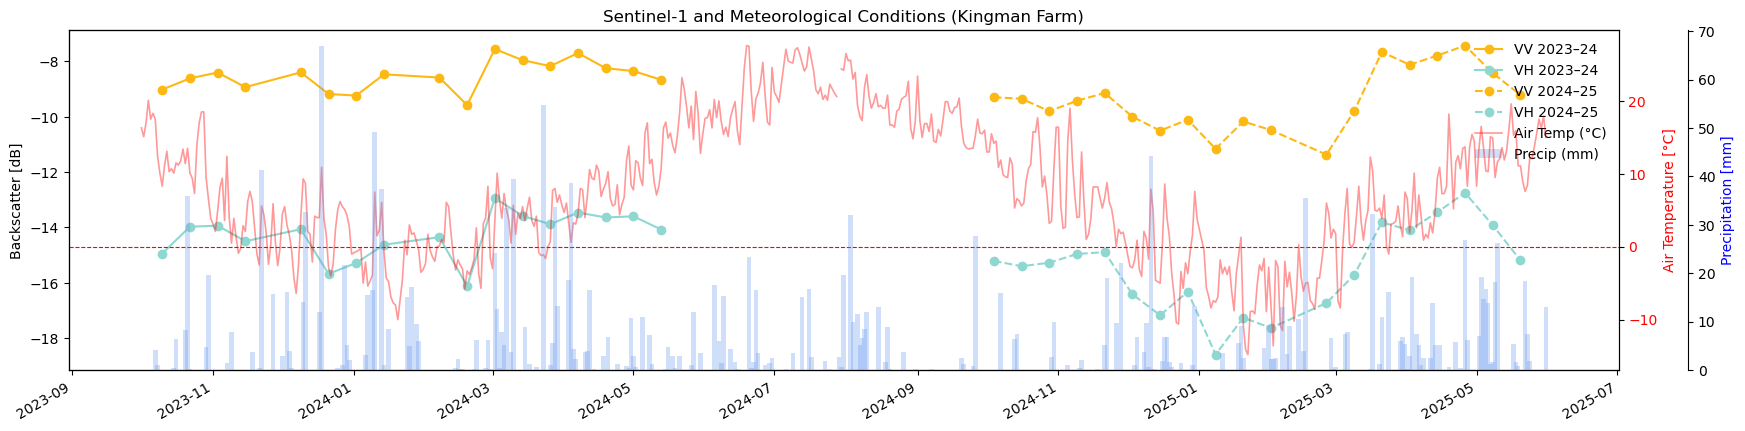

In [6]:
# Time series plot: Backscatter + Meteorological data

start, end = "2023-10-01", "2025-05-31"
Met = Met.loc[start:end]
mean_backscatter = mean_backscatter.loc[start:end]

fig, ax1 = plt.subplots(figsize=(20, 5))

# (1) Backscatter (left y-axis)
ax1.plot(mean_backscatter.index, mean_backscatter["VV_2023_24"], "o-", color="#FDB913", label="VV 2023–24")
ax1.plot(mean_backscatter.index, mean_backscatter["VH_2023_24"], "o-", color="#8FD8D2", label="VH 2023–24")
ax1.plot(mean_backscatter.index, mean_backscatter["VV_2024_25"], "o--", color="#FDB913", label="VV 2024–25")
ax1.plot(mean_backscatter.index, mean_backscatter["VH_2024_25"], "o--", color="#8FD8D2", label="VH 2024–25")

ax1.set_ylabel("Backscatter [dB]", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# (2) Air temperature (right y-axis)
ax2 = ax1.twinx()
ax2.plot(Met.index, Met["T_DAILY_MEAN"], color="red", alpha=0.4, linewidth=1.2, label="Air Temp (°C)")
ax2.axhline(0, color="red", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Air Temperature [°C]", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# (3) Precipitation (right outer y-axis)
ax3 = ax1.twinx()
ax3.bar(Met.index, Met["P_DAILY_CALC"], color="cornflowerblue", alpha=0.3, width=2, label="Precip (mm)")
ax3.spines["right"].set_position(("outward", 50))
ax3.set_ylabel("Precipitation [mm]", color="blue")

# legends
lines, labels = [], []
for ax in [ax1, ax2, ax3]:
    l, lb = ax.get_legend_handles_labels()
    lines += l; labels += lb
ax1.legend(lines, labels, loc="upper right", frameon=False)

ax1.set_title("Sentinel-1 and Meteorological Conditions (Kingman Farm)")
fig.autofmt_xdate()
plt.show()

VH shows greater temporal variability compared to VV. Both tend to decrease when air temperature is low and increase when it is high.  
One interesting event appears in January 2025: despite low temperature (< 0 C) and limited precipitation, VH drops significantly. I suspect this may be due to prolonged cold conditions leading to frozen soil, which reduces VH backscatter.

# Next step

To further verify whether this signal is related to snow or wet-snow conditions, it might be useful to compare with NDSI data.